## ENSO


Your task is to explore and analyze the ENSO dataset and create a predictive model for
ENSO anomaly values. The project is divided into two parts. In the first part, you will focus
on Exploratory Data Analysis (EDA) to gain a deep understanding of the dataset, including
its variables and their relationships. In the second part, you will apply machine learning
techniques to predict ENSO anomalies. We encourage you to explore additional data
sources if you find them valuable for your analysis. You can find valuable information for the
project on the following page: ENSO Information.

## Getting the dataset and creating the dataset
Based on the ENSO webpage, most of the data is stored in a api, so for that we need to request the data using an API

In [1]:
#Libraries used to acquiring data
import requests

#Libraries used for Exploratory Data Analysis
import numpy as np
import pandas as pd

#Libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Libraries for first Machine Learning Model
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#Libraries for second Machine Learning Model
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, TimeDistributed
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.linear_model import Ridge

# Just to remove some warnings
import warnings
warnings.filterwarnings("ignore")
     

2023-10-15 16:33:32.624673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


I'm going to be working with the Pacific Sea Surface Temperatures since I found the data shows the date, regions and temperatures which are going to be useful to show the anomalities 

In [2]:
#Getting the url from the webpage 
# Equatorial Pacific Sea Surface Temperatures (SST) is the dataset used in this case
url = 'https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices'
# using the request format to get a response
response = requests.get(url)

In [3]:
#checking the status of the request, if the result is "200" the api was sucessfully implemented
response.status_code

200

In [4]:
#Once I know that the status code was "200" I have to dig into the dataset
if response.status_code == 200:
    with open("nino4.long.anom.data", 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
else:
    print("Failed to download the file.")

File downloaded successfully.


In [5]:
# the file path of our dataset
file_path = "nino4.long.anom.data"
#now we are openning the file
with open(file_path, 'r') as file:
    data = file.read()

# I print the data to visualize it 
print(data)

YR MON  NINO1+2   ANOM   NINO3    ANOM   NINO4    ANOM NINO3.4    ANOM
1982   1   24.28   -0.24   25.84    0.17   28.01   -0.21   26.65    0.08
1982   2   25.38   -0.72   26.26   -0.11   27.99   -0.11   26.54   -0.20
1982   3   25.22   -1.38   26.92   -0.25   28.18   -0.05   27.09   -0.14
1982   4   24.57   -1.16   27.52   -0.05   28.61    0.10   27.83    0.02
1982   5   24.00   -0.62   27.70    0.49   29.19    0.40   28.37    0.49
1982   6   22.88   -0.29   27.10    0.46   29.46    0.62   28.35    0.65
1982   7   22.07    0.24   26.14    0.27   28.76   -0.02   27.57    0.27
1982   8   21.71    0.85   26.05    0.83   28.70    0.01   27.76    0.86
1982   9   21.91    1.33   26.50    1.49   28.91    0.24   28.01    1.24
1982  10   22.67    1.80   27.04    1.96   29.11    0.43   28.50    1.73
1982  11   24.40    2.78   27.39    2.19   28.85    0.18   28.50    1.68
1982  12   25.73    2.89   28.07    2.80   28.81    0.36   28.85    2.21
1983   1   26.82    2.30   28.37    2.69   28.63    0

## Creating the dataset
For this, I know that the dataset is in form "string", so I have to split each line of the string, then separating and splitting the columns from the values

In [6]:
#getting the values from the first row
lines = data.split('\n')
#now separating the first row from the rest of the dataframe because it is the name of the columns
columns = lines[0].split()
#getting all the values except for the first row and splitting them 
values = [line.split() for line in lines[1:]]


In [7]:
df = pd.DataFrame(values, columns = columns)
df

,YR,MON,NINO1+2,ANOM,NINO3,ANOM,NINO4,ANOM,NINO3.4,ANOM
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49
...,...,...,...,...,...,...,...,...,...,...
497,2023,6,25.81,2.63,27.85,1.21,29.48,0.64,28.59,0.88
498,2023,7,25.05,3.21,27.47,1.59,29.50,0.71,28.37,1.07
499,2023,8,24.16,3.30,27.17,1.96,29.65,0.95,28.20,1.30
500,2023,9,23.40,2.82,27.08,2.07,29.77,1.10,28.29,1.53


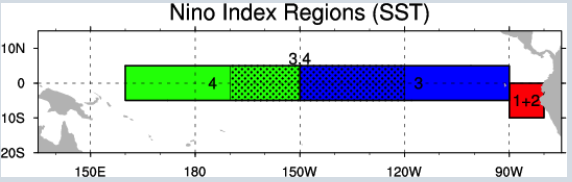

After a little of digging on the internet, I was wondering what does the Nino 4, 1+2, 3 and 3.4 mean. I assume that these columns would all mean the same category but in different stations but I was wrong. Based on the information provided in "https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni" they all mean the regions in which they measure the data, being the region 3.4 "the most commonly used indices to define el Niño events. 

Also, based on the webpage provided "https://www.ncei.noaa.gov/access/monitoring/enso/sst" ANOM would mean anomalies. Anomalies in the Niño 3.4 region that is above (below) the threshold of +0.5°C (-0.5°C). This standard of measure is known as the Oceanic Niño Index (ONI).

## Exploratory Data Analysis

## Cleaning Missing Values 

In [8]:
#I want to know how many not a number values (nan)my dataset contains and I want to know if there are rows or columns with 
#missing values

#Missing values per column
nan_columns = df.isna().sum(axis = 0)
print(f"missing values per column:{nan_columns}")
#Missing values per row
nan_rows = df.isna().sum(axis = 1)
print(f"missing values per row:{nan_rows}")

missing values per column:YR         1
MON        1
NINO1+2    1
ANOM       1
NINO3      1
ANOM       1
NINO4      1
ANOM       1
NINO3.4    1
ANOM       1
dtype: int64
missing values per row:0       0
1       0
2       0
3       0
4       0
       ..
497     0
498     0
499     0
500     0
501    10
Length: 502, dtype: int64


I have concluded that there is only one row (501) with a missing value this row also 

In [9]:
df = df.dropna()
df

,YR,MON,NINO1+2,ANOM,NINO3,ANOM,NINO4,ANOM,NINO3.4,ANOM
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49
...,...,...,...,...,...,...,...,...,...,...
496,2023,5,26.63,2.02,28.11,0.90,29.12,0.33,28.35,0.47
497,2023,6,25.81,2.63,27.85,1.21,29.48,0.64,28.59,0.88
498,2023,7,25.05,3.21,27.47,1.59,29.50,0.71,28.37,1.07
499,2023,8,24.16,3.30,27.17,1.96,29.65,0.95,28.20,1.30


### Casting types of data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   YR       501 non-null    object
 1   MON      501 non-null    object
 2   NINO1+2  501 non-null    object
 3   ANOM     501 non-null    object
 4   NINO3    501 non-null    object
 5   ANOM     501 non-null    object
 6   NINO4    501 non-null    object
 7   ANOM     501 non-null    object
 8   NINO3.4  501 non-null    object
 9   ANOM     501 non-null    object
dtypes: object(10)
memory usage: 43.1+ KB


In [11]:
df.columns 

Index(['YR', 'MON', 'NINO1+2', 'ANOM', 'NINO3', 'ANOM', 'NINO4', 'ANOM',
       'NINO3.4', 'ANOM'],
      dtype='object')

In [12]:
df['date'] = df['YR'] + '-' + df['MON']
df['date'] = pd.to_datetime(df['date'], errors='coerce', format='%Y-%m')
#df['date'] = df['date'].dt.to_period('M')
df['Months'] = (df['date'] - df['date'].min()).dt.days // 30
df

,YR,MON,NINO1+2,ANOM,NINO3,ANOM,NINO4,ANOM,NINO3.4,ANOM,date,Months
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,1982-01-01,0
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,1982-02-01,1
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,1982-03-01,1
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,1982-04-01,3
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,1982-05-01,4
...,...,...,...,...,...,...,...,...,...,...,...,...
496,2023,5,26.63,2.02,28.11,0.90,29.12,0.33,28.35,0.47,2023-05-01,503
497,2023,6,25.81,2.63,27.85,1.21,29.48,0.64,28.59,0.88,2023-06-01,504
498,2023,7,25.05,3.21,27.47,1.59,29.50,0.71,28.37,1.07,2023-07-01,505
499,2023,8,24.16,3.30,27.17,1.96,29.65,0.95,28.20,1.30,2023-08-01,506


Since, the data is numerical, we need to change these values from object into numerical

In [13]:
dictionary = {'YR': "int", "MON":"int", 
               'NINO1+2':"float", 'ANOM':"float", 'NINO3':"float", 'ANOM':"float", 'NINO4':"float", 'ANOM':"float",
       'NINO3.4':"float", 'ANOM':"float"
              }

#Changing the values to a float, they can't be integers because the data contains decimal points
df = df.astype(dictionary)
#df[['YR', "MON"]] = df[['YR', "MON"]].astype(int)
# As we can see the columns "YR" is the year recorded, I could change this to numerical but in this case I would try to
#use a datetime, later if I see this is getting an obstacle in my analysis I would change it to numerical (int)
## *** df['YR']= df['YR'].astype('datetime64[ns]')*** ##

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   YR       501 non-null    int64         
 1   MON      501 non-null    int64         
 2   NINO1+2  501 non-null    float64       
 3   ANOM     501 non-null    float64       
 4   NINO3    501 non-null    float64       
 5   ANOM     501 non-null    float64       
 6   NINO4    501 non-null    float64       
 7   ANOM     501 non-null    float64       
 8   NINO3.4  501 non-null    float64       
 9   ANOM     501 non-null    float64       
 10  date     501 non-null    datetime64[ns]
 11  Months   501 non-null    int64         
dtypes: datetime64[ns](1), float64(8), int64(3)
memory usage: 50.9 KB


In [15]:
#shape of the dataset
df.shape

(501, 12)

In [16]:
# name of the columns
df.columns 
# Since several columns are called, "ANOM" we need to change this to the column they are assigned to and also change
#the column "NINO1+2"
d = {"ANOM": ["ANOM1_2", "ANOM3", "ANOM4", "ANOM3.4"]}
df = df.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
df = df.rename(columns = {"NINO1+2":'NINO1_2'})
df['date']


0     1982-01-01
1     1982-02-01
2     1982-03-01
3     1982-04-01
4     1982-05-01
         ...    
496   2023-05-01
497   2023-06-01
498   2023-07-01
499   2023-08-01
500   2023-09-01
Name: date, Length: 501, dtype: datetime64[ns]

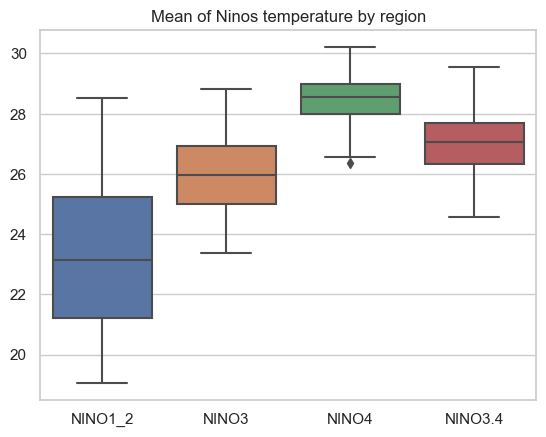

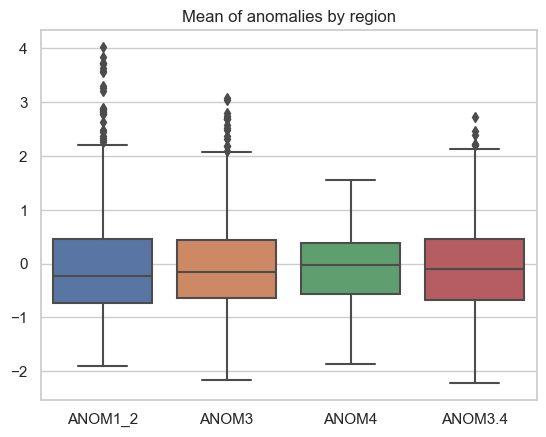

In [17]:
#visualizing the data,
sns.set(style="whitegrid")
plt.title('Mean of Ninos temperature by region')
ax1 = sns.boxplot(data=df[['NINO1_2', 'NINO3', 'NINO4', 'NINO3.4']])
plt.show()
plt.title('Mean of anomalies by region')
ax2 = sns.boxplot(data=df[['ANOM1_2', 'ANOM3', 'ANOM4', 'ANOM3.4']])

We can see, that temperatures are different in each region, being further away means temperatures are hotter than the region closest to the shore. 
Another interesting fact is that we could find a lot of outliers in region1_2 (anomalies) we can hypothesized that the region closest to the shore and hence closest to human activities can have a greater impact in the flactuations of temperatures.  

## Descriptive Statistics

In [18]:
df.groupby('YR').size()
described = df.groupby('YR').agg(['mean', 'median', 'std'])
described = described[['NINO1_2', 'NINO3', 'NINO4', 'NINO3.4','ANOM1_2', 'ANOM3', 'ANOM4', 'ANOM3.4']]
described 

NINO1_2                        NINO3                        NINO4  \
           mean  median       std       mean  median       std       mean   
YR                                                                          
1982  23.735000  24.140  1.429135  26.877500  26.980  0.718624  28.715000   
1983  25.375000  26.255  2.609554  26.781667  27.325  1.862173  28.292500   
1984  22.695833  22.415  2.064943  25.310833  24.920  1.147016  27.791667   
1985  22.092500  22.085  2.168976  24.967500  24.560  0.911543  27.824167   
1986  22.883333  22.560  1.992177  25.850000  25.790  0.659214  28.390000   
1987  24.052500  23.555  2.161801  26.859167  26.675  0.787729  28.925000   
1988  22.115833  21.625  2.552134  24.855000  24.275  1.434785  27.745833   
1989  22.694167  22.145  2.373434  25.246667  25.055  0.823533  27.624167   
1990  22.642500  22.445  2.253144  25.840000  25.495  0.921284  28.639167   
1991  23.215000  23.100  1.928162  26.301667  26.290  0.810711  28.905833   
1992  23.532500  23.035  2.664061  26.342500  26.255  1.456978  28.772500   
1993  23.445000  22.995  2.214032  26.234167  25.850  1.118769  28.602500   
1994  22.875833  22.940  1.972633  25.982500  26.000  0.747981  28.841667   
1995  22.769167  22.205  2.299535  25.508333  25.770  1.180623  28.572500   
1996  22.225000  21.765  2.313335  25.310000  25.090  0.905629  28.148333   
1997  25.463333  25.530  1.063770  27.243333  27.595  1.071035  28.880000   
1998  24.774167  24.280  2.954976  26.385833  25.930  2.024718  28.023333   
1999  22.510000  22.260  2.312346  25.029167  24.765  1.246883  27.403333   
2000  22.685000  22.560  2.364435  25.291667  24.855  1.090828  27.640000   
2001  22.828333  22.340  2.570029  25.664167  25.375  1.126898  28.297500   
2002  23.653333  23.515  2.219600  26.339167  26.230  0.799334  29.046667   
2003  23.049167  22.550  2.087384  26.108333  26.000  0.709671  28.836667   
2004  23.058333  22.750  2.178289  26.170833  26.025  0.703168  28.916667   
2005  22.621667  22.315  2.280087  25.844167  25.970  1.201434  28.771667   
2006  23.632500  23.425  1.683930  26.189167  26.095  0.676481  28.678333   
2007  22.449167  21.760  2.714431  25.375833  25.715  1.375536  28.392500   
2008  23.675833  23.180  2.010619  25.805000  25.570  0.960535  27.700833   
2009  23.629167  23.680  1.899595  26.459167  26.390  0.720851  28.735833   
2010  22.715833  22.500  2.797998  25.667500  25.540  1.681769  28.255000   
2011  22.983333  22.800  2.329906  25.430000  25.230  1.132415  27.878333   
2012  23.448333  23.150  2.293532  26.105833  26.025  0.974264  28.318333   
2013  22.440833  22.050  2.402746  25.670000  25.295  0.967396  28.431667   
2014  23.615833  23.790  1.678568  26.365833  26.055  0.936914  28.837500   
2015  24.671667  24.760  1.415433  27.457500  27.520  0.607530  29.536667   
2016  23.871667  23.400  2.394049  26.385000  26.015  1.653583  28.943333   
2017  23.312500  22.385  3.093971  25.954167  25.830  1.427442  28.545000   
2018  23.059167  23.075  1.859626  26.045833  26.130  0.757621  28.849167   
2019  23.278333  23.130  2.702574  26.401667  26.170  1.203275  29.287500   
2020  22.857500  22.145  2.636599  25.682500  25.670  1.331801  28.578333   
2021  22.779167  22.600  1.992182  25.524167  25.415  0.993529  28.125833   
2022  22.166667  22.155  2.247400  25.220833  25.005  0.947115  27.820833   
2023  25.824444  25.810  1.735058  27.182222  27.470  0.944335  28.846667   

                          NINO3.4  ...   ANOM1_2     ANOM3                   \
      median       std       mean  ...       std      mean median       std   
YR                                 ...                                        
1982  28.785  0.459654  27.835000  ...  1.466643  0.854167  0.475  1.011843   
1983  28.475  0.477800  27.290000  ...  1.259960  0.757500  0.935  1.152350   
1984  27.930  0.372823  26.337500  ...  0.332487 -0.713333 -0.835  0.435125   
1985  27.965  0.354053  26.220000  ...  0.358747 -1.058333 -0.980  0

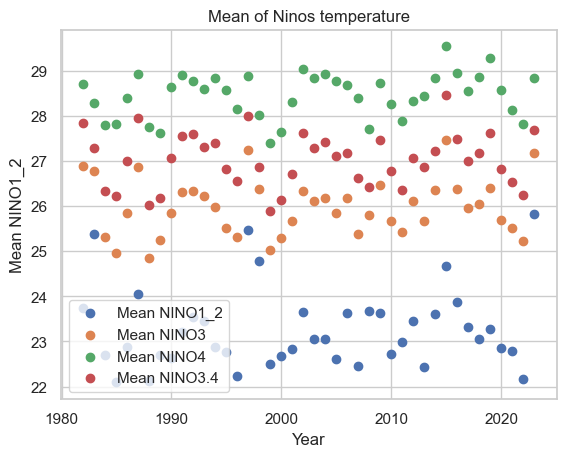

In [19]:
plt.scatter(described.index, described[('NINO1_2', 'mean')], label='Mean NINO1_2')
plt.scatter(described.index, described[('NINO3', 'mean')], label='Mean NINO3')
plt.scatter(described.index, described[('NINO4', 'mean')], label='Mean NINO4')
plt.scatter(described.index, described[('NINO3.4', 'mean')], label='Mean NINO3.4')
plt.xlabel('Year')
plt.ylabel('Mean NINO1_2')
plt.title('Mean of Ninos temperature')
plt.legend()
plt.show()

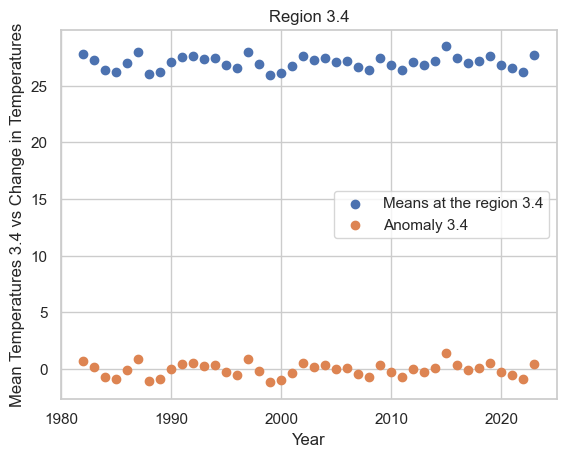

In [20]:
plt.scatter(described.index, described[('NINO3.4', 'mean')], label='Means at the region 3.4')
plt.scatter(described.index, described[('ANOM3.4', 'mean')], label='Anomaly 3.4')
plt.xlabel('Year')
plt.ylabel('Mean Temperatures 3.4 vs Change in Temperatures')
plt.title('Region 3.4')
plt.legend()
plt.show()

The data shows that there is a pattern between anomalies and the region 3.4 

# Correlation

In [21]:
df.corr()

,YR,MON,NINO1_2,ANOM1_2,NINO3,ANOM3,NINO4,ANOM4,NINO3.4,ANOM3.4,Months
YR,1.000000,-0.013387,0.015505,0.019321,0.038938,0.045600,0.158981,0.171198,0.031848,0.031313,0.999714
MON,-0.013387,1.000000,-0.708109,0.014105,-0.478000,0.003268,0.200964,-0.000441,-0.123704,0.004400,0.010432
NINO1_2,0.015505,-0.708109,1.000000,0.436616,0.783083,0.358189,-0.028689,0.196426,0.395587,0.279169,-0.001538
ANOM1_2,0.019321,0.014105,0.436616,1.000000,0.551033,0.810501,0.412312,0.436090,0.554010,0.635123,0.019324
NINO3,0.038938,-0.478000,0.783083,0.551033,1.000000,0.689316,0.436385,0.512504,0.849452,0.646957,0.027144
ANOM3,0.045600,0.003268,0.358189,0.810501,0.689316,1.000000,0.683803,0.731187,0.821176,0.938430,0.045173
NINO4,0.158981,0.200964,-0.028689,0.412312,0.436385,0.683803,1.000000,0.935311,0.802807,0.823437,0.163306
ANOM4,0.171198,-0.000441,0.196426,0.436090,0.512504,0.731187,0.935311,1.000000,0.778455,0.881354,0.170709
NINO3.4,0.031848,-0.123704,0.395587,0.554010,0.849452,0.821176,0.802807,0.778455,1.000000,0.875451,0.028376
ANOM3.4,0.031313,0.004400,0.279169,0.635123,0.646957,0.938430,0.823437,0.881354,0.875451,1.000000,0.030874


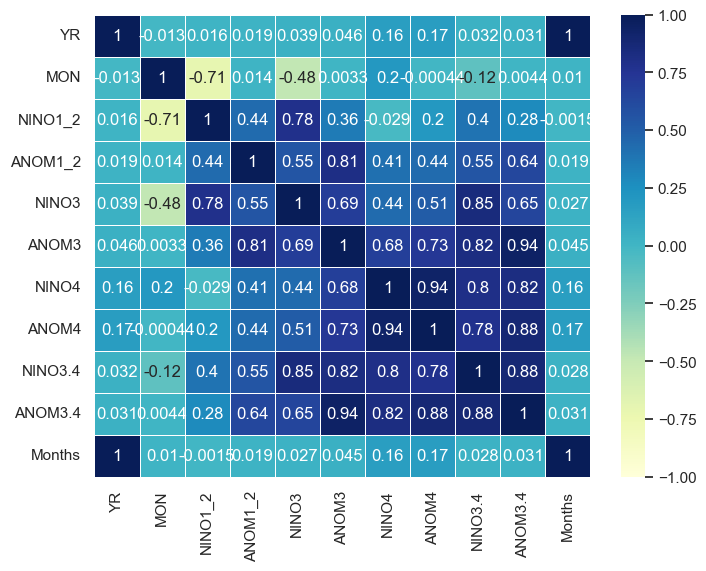

In [22]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5)

I made a correlation because in my internal process I thought the data was going to fit in a linear regression, but then I noticed that this case is not a simple linear regression but a time series. I left the notebook unchanged so I can show my internal process as data scientist instead of showing a "all correct-solution notebook"

## Machine Learning  (Time Series using LinearRegression())

This dataset contains labels, hence we can only applied supervised algorithms. If we tried to make a prediction based on the previous dates, we can use a time series algorithm to show a predict anomaly

In [23]:
# Convert date to ordinal
X = df[['Months']]
y = df['ANOM3.4']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for the model
X_train = np.array(X_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)



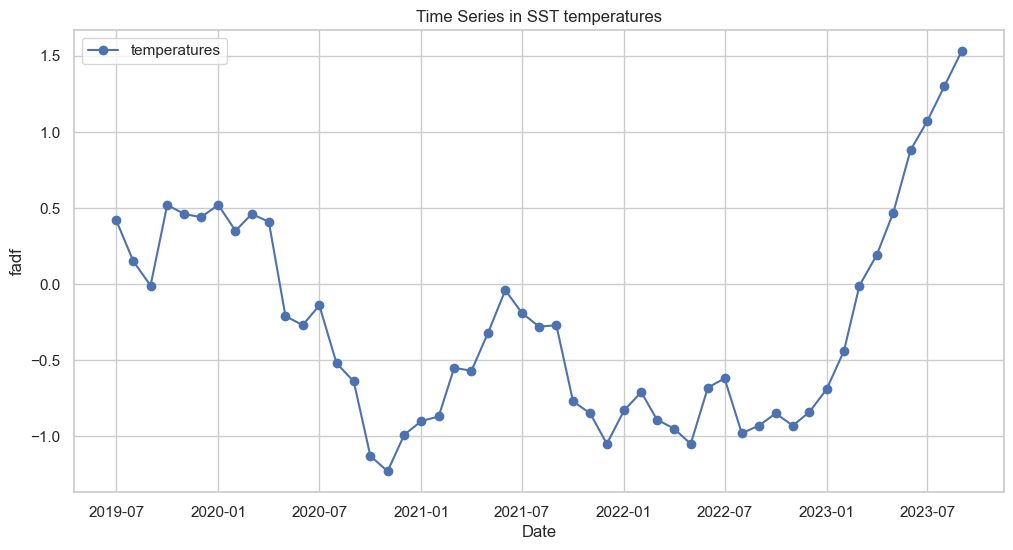

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'][450:], df['ANOM3.4'][450:], label='temperatures', marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('fadf')
plt.title('Time Series in SST temperatures')
plt.legend()
plt.show()

In [25]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
     

LinearRegression()

In [26]:
# Realizar predicciones en el conjunto de prueba
y_pred = regression_model.predict(X_test)   


In [27]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

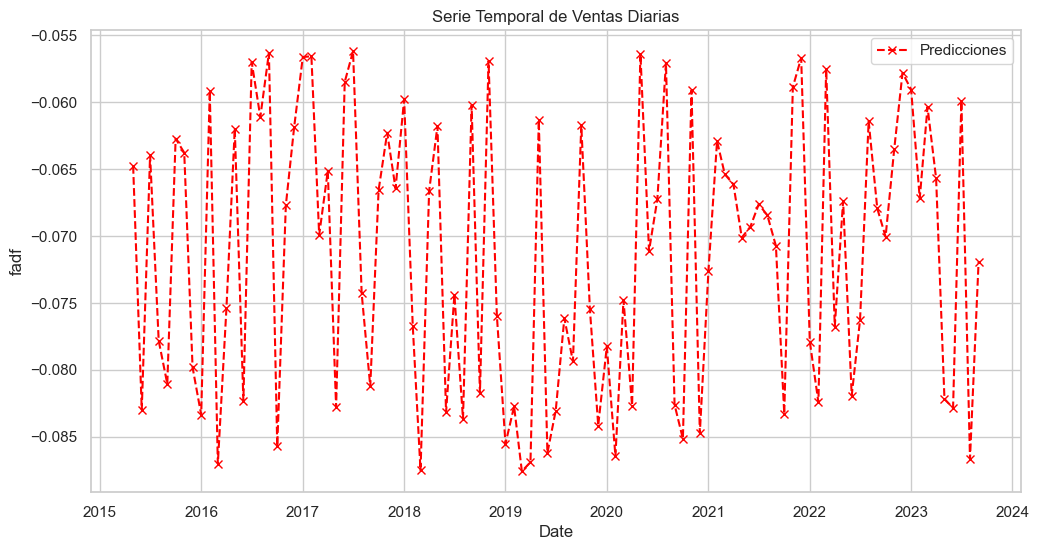

MSE : 0.9131762307759517
R^2: 0.0017522997300092324


In [28]:
plt.figure(figsize=(12, 6))
#plt.plot(df['date'][450:], df['ANOM3.4'][450:], label='Ventas Diarias', marker='o', linestyle='-')
plt.plot(df['date'][len(X_train):], y_pred, label='Predicciones', marker='x', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('fadf')
plt.title('Serie Temporal de Ventas Diarias')
plt.legend()
plt.show()

# print the results
print("MSE :", mse)
print("R^2:", r2)
     

Since the mean-square error is too high and R-square shows a bad performance in the predicted value, I decided that this algorithm did not predict correctly a set forecasted values. So I went back to my college note and I did a similar procedure using the same tool the LinearRegression() with a more changed dataset. Next I continue to applied the same approach but now looking at my college notes and a more well refined values.


## Machine Learning  (Time Series using my college's notebook)

In [29]:
# Use only the columns of importance. Since We only want to predict the anomalies, I would only select datetimes and
# -- temperatures of the anom3.4 column 
new_df = df[['date', 'ANOM3.4']]
new_df 

,date,ANOM3.4
0,1982-01-01,0.08
1,1982-02-01,-0.20
2,1982-03-01,-0.14
3,1982-04-01,0.02
4,1982-05-01,0.49
...,...,...
496,2023-05-01,0.47
497,2023-06-01,0.88
498,2023-07-01,1.07
499,2023-08-01,1.30


now, with this approach I want to make a formula such that it takes the dates and tranpose them so I can use the values of dates as columns and anom3.4 the values of my columns. Like a type of "cross-validation" where we take one element and applying the training to the rest.

In [30]:
def transformarSerieaDataset(serie, elementspormuestra):
    dataset = None
    salidasDataset = None
    for counter in range(len(serie) - elementspormuestra - 1):
        muestra = np.array([serie[counter:counter + elementspormuestra]])
        salida = np.array([serie[counter + elementspormuestra]])
        if dataset is None:
            dataset = muestra
        else:
            dataset = np.append(dataset, muestra, axis=0)
        if salidasDataset is None:
            salidasDataset = salida
        else:
            salidasDataset = np.append(salidasDataset, salida)
    return dataset, salidasDataset

In [31]:
serie = new_df['ANOM3.4'].to_numpy()
# What I'm telling my code is that based on 10 months, to predict the weather for the next month. I can change that 
# with the elementspormuestra but for now I'll just set it to 10
X, Y = transformarSerieaDataset(serie, elementspormuestra = 10)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=5)


In [33]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [34]:
y_train_predict = lin_model.predict(X_train)
MSE = mean_squared_error(y_train, y_train_predict)
print("training: MSE= ", str(MSE))

y_test_predict = lin_model.predict(X_test)
MSE = (mean_squared_error(y_test, y_test_predict))
print('test: MSE='+str(MSE))

training: MSE=  0.05918793515239283
test: MSE=0.07044642075704947


In [35]:
df_predictions = pd.DataFrame({'Real value':y_test, 'predictions':y_test_predict, 'difference': y_test - y_test_predict})
df_predictions = df_predictions.reset_index(drop= True)
df_predictions.head(10)

,Real value,predictions,difference
0,0.66,0.573128,0.086872
1,0.42,0.393271,0.026729
2,-1.48,-1.617755,0.137755
3,-0.20,-0.518266,0.318266
4,-0.55,-0.592793,0.042793
5,-0.99,-1.030393,0.040393
6,-0.34,-0.971297,0.631297
7,0.75,0.600281,0.149719
8,-0.60,-0.745723,0.145723
9,-0.56,-0.633922,0.073922


In this case, "Real Value" would mean the anomaly value that we have, predictions is the outcome that our algorithm gave based on the previous datapoints. Difference shows how much my algorithm differs from the actual value. 

## Using Ridge function to "forecast" the values of the next anomalies at the Region 3.4

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and fit the Ridge regression model
ridge = Ridge(alpha=1.0)  # You can set the alpha parameter as per your requirements
ridge.fit(X_train, y_train)

# Make predictions
y_pred = ridge.predict(X_test)

# Assess the model
ridge_score = ridge.score(X_test, y_test)
print("Ridge regression score: {:.2f}".format(ridge_score))

Ridge regression score: 0.89


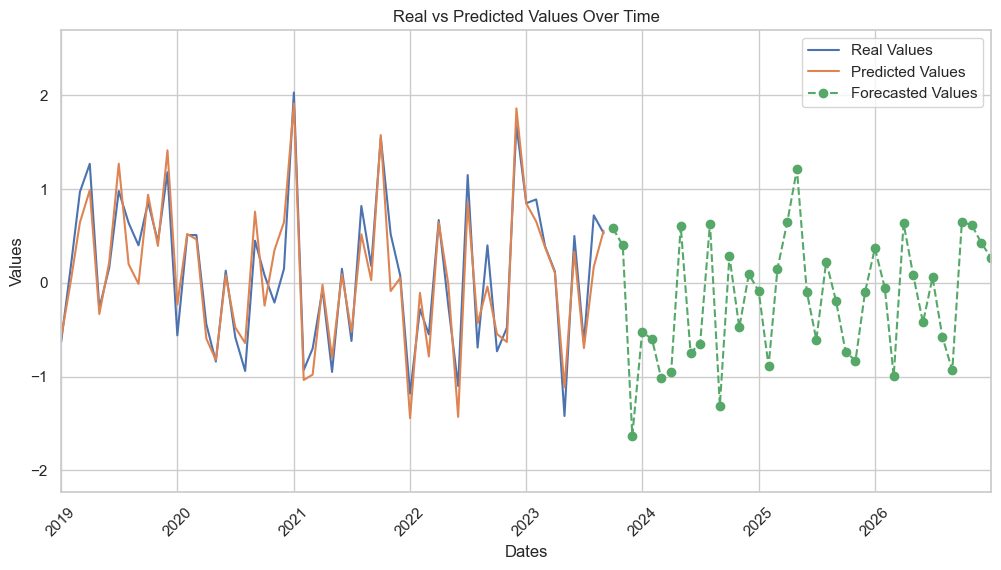

In [37]:
num_forecast_points = len(y_pred)  # Assuming y_pred contains the predicted values
last_date = df['date'].iloc[-1]  # Assuming df is your DataFrame
future_dates = pd.date_range(last_date, periods=num_forecast_points, freq='M')


plt.figure(figsize=(12, 6))
plt.plot(new_df['date'][-len(y_test):], y_test, label='Real Values')
plt.plot(new_df['date'][-len(y_test):], y_test_predict, label='Predicted Values')
plt.plot(future_dates, y_pred, label='Forecasted Values', linestyle='--', marker='o')
plt.xlabel('Dates')
plt.ylabel('Values')
plt.title('Real vs Predicted Values Over Time')
plt.legend()
plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2026-12-31'))
plt.xticks(rotation=45)
plt.show()



In [38]:
next_temp = pd.DataFrame(y_pred, future_dates)
next_temp.head(10)

,0
2023-09-30,0.581734
2023-10-31,0.402445
2023-11-30,-1.630451
2023-12-31,-0.521753
2024-01-31,-0.601910
2024-02-29,-1.019086
2024-03-31,-0.951795
2024-04-30,0.608068
2024-05-31,-0.744763
2024-06-30,-0.648284
